In [1]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
from torchsummary import summary
from sklearn.metrics import precision_score, f1_score,recall_score,accuracy_score
from torch.optim.lr_scheduler import StepLR

!pip install torchview
import torchvision
from torchview import draw_graph

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir output

In [4]:
import torch
import torch.nn as nn
from torchvision.models import vgg13_bn, vgg16_bn

__all__ = ['vgg13bn_unet', 'vgg16bn_unet']


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class VGGUnet(nn.Module):
    """Unet with VGG-13 (with BN), VGG-16 (with BN) encoder.
    """

    def __init__(self,encoder,pretrained=True, out_channels=1):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=True).features
        for param in self.encoder.parameters():
          param.requires_grad=False

        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = double_conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = double_conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = double_conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = double_conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = double_conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = double_conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        if x.shape != block5.shape:
          x = TF.resize(x,size = block5.shape[2:])

        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        if x.shape != block4.shape:
          x = TF.resize(x,size = block4.shape[2:])

        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        if x.shape != block3.shape:
          x = TF.resize(x,size = block3.shape[2:])

        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
 
        x = self.up_conv9(x)
        if x.shape != block2.shape:
            x = TF.resize(x,size = block2.shape[2:])

        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        if x.shape != block1.shape:
            x = TF.resize(x,size = block1.shape[2:])

        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x


def vgg13bn_unet(output_dim: int=2, pretrained: bool=False):
    return VGGUnet(vgg13_bn, pretrained=pretrained, out_channels=output_dim)


def vgg16bn_unet(output_dim: int=1, pretrained: bool=True):
    return VGGUnet(vgg16_bn, pretrained=pretrained, out_channels=output_dim)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16bn_unet().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:01<00:00, 289MB/s]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


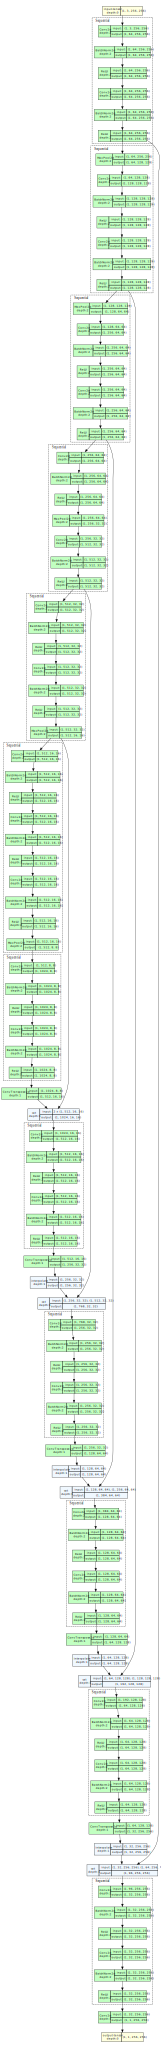

In [6]:
model_graph = draw_graph(model, input_size=(1,3,256,256), expand_nested=True)
model_graph.visual_graph

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

In [8]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.masks)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.masks[index])

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    mask = (mask//246.0)
    image = (image/255.0)


    if self.transform != None:
      augment = self.transform(image = image,mask = mask)
      image = augment['image']
      mask = augment['mask']

      if(image.shape[1:] != mask.shape):
        print("-------------- ---------------------------")
        print("!!!Warning!!!")
        print(image.shape[1:])
        print(mask.shape)

    return image,mask

Just for checking the above code

In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader

In [10]:
def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

In [11]:
def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

In [12]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader

In [13]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loss_fn,loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      val_loss += loss_fn(y,pred).item()

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()


      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        # F1-score is the harmonic mean of Precision and Recall,
        # F1-score = 2 * (Precision * Recall) / (Precision + Recall)

        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  val_loss /= len(loader)
  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

In [14]:
def save_predictions_as_imgs(loader,model,folder="saved_images/",device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      # preds = (preds > 0.5).astype(torch.int)

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [15]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# Hyperparameters
LEARNING_RATE = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 15
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8

PIN_MEMORY = True
LOAD_MODEL = True

TRAIN_IMG_DIR = '/kaggle/input/slum-dataset/train_img/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slum-dataset/train_mask-20230822T130205Z-001/train_mask'
val_dir = '/kaggle/input/slum-dataset/val_img-20230822T130211Z-001/val_img'
val_mask_dir = '/kaggle/input/slum-dataset/val_mask-20230822T130216Z-001/val_mask'
saved_folder = '/kaggle/working/'

/tmp/ipykernel_26/1993719355.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [16]:
# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

In [17]:
def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0
  accuracy_s = []

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
    
      for pred_mask,gt_mask in zip(preds,yy):
        x = np.mean(gt_mask.flatten() == pred_mask.flatten())
        accuracy_s.append(x)

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      # total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  # average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(np.mean(accuracy_s))

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {np.mean(accuracy_s):4f}"
  )


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See m

Epoch [1/15], Loss: 0.1947, IoU: 0.5709, Precision: 0.6850, Recall: 0.7765, F1: 0.7220,Accuracy: 0.833092
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 40561641/46530560 with accuracy 87.17204284667969
Average Precision: 0.5772
Accuracy: 0.8717204564054247
Average Dice Score: 0.6973
Average F1 Score: 0.6973
Average IoU Score: 0.5539


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<12:33,  4.26s/it, loss=0.201]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [2/15], Loss: 0.1767, IoU: 0.6112, Precision: 0.7196, Recall: 0.8094, F1: 0.7565,Accuracy: 0.855345
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 40851152/46530560 with accuracy 87.79423522949219
Average Precision: 0.5953
Accuracy: 0.8779424103213028
Average Dice Score: 0.7111
Average F1 Score: 0.7111
Average IoU Score: 0.5704


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:02<08:48,  2.99s/it, loss=0.159]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [3/15], Loss: 0.1694, IoU: 0.6194, Precision: 0.7652, Recall: 0.7722, F1: 0.7632,Accuracy: 0.866407
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41600224/46530560 with accuracy 89.40409088134766
Average Precision: 0.6324
Accuracy: 0.8940409055897888
Average Dice Score: 0.7415
Average F1 Score: 0.7415
Average IoU Score: 0.6073


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<11:59,  4.07s/it, loss=0.193]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [4/15], Loss: 0.1652, IoU: 0.6322, Precision: 0.7889, Recall: 0.7677, F1: 0.7732,Accuracy: 0.874378
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41174935/46530560 with accuracy 88.4900894165039
Average Precision: 0.6182
Accuracy: 0.8849009124326034
Average Dice Score: 0.7316
Average F1 Score: 0.7316
Average IoU Score: 0.5962


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:58,  4.74s/it, loss=0.155]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [5/15], Loss: 0.1641, IoU: 0.6382, Precision: 0.7938, Recall: 0.7707, F1: 0.7775,Accuracy: 0.876450
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 42645595/46530560 with accuracy 91.65072631835938
Average Precision: 0.7108
Accuracy: 0.9165072373940911
Average Dice Score: 0.7801
Average F1 Score: 0.7801
Average IoU Score: 0.6552


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:19,  4.52s/it, loss=0.15]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

Epoch [6/15], Loss: 0.1631, IoU: 0.6430, Precision: 0.8010, Recall: 0.7712, F1: 0.7814,Accuracy: 0.878694
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41927464/46530560 with accuracy 90.10736846923828
Average Precision: 0.6641
Accuracy: 0.9010737029599472
Average Dice Score: 0.7572
Average F1 Score: 0.7572
Average IoU Score: 0.6276


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:15,  4.49s/it, loss=0.154]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [7/15], Loss: 0.1628, IoU: 0.6400, Precision: 0.7998, Recall: 0.7686, F1: 0.7790,Accuracy: 0.878370
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41087394/46530560 with accuracy 88.30194091796875
Average Precision: 0.6297
Accuracy: 0.8830195467237015
Average Dice Score: 0.7317
Average F1 Score: 0.7317
Average IoU Score: 0.5983


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<14:10,  4.81s/it, loss=0.133]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [8/15], Loss: 0.1621, IoU: 0.6475, Precision: 0.8037, Recall: 0.7740, F1: 0.7844,Accuracy: 0.880983
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41068738/46530560 with accuracy 88.26185607910156
Average Precision: 0.6243
Accuracy: 0.8826186059226453
Average Dice Score: 0.7322
Average F1 Score: 0.7322
Average IoU Score: 0.5979


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:24,  4.55s/it, loss=0.159]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [9/15], Loss: 0.1620, IoU: 0.6458, Precision: 0.8065, Recall: 0.7700, F1: 0.7835,Accuracy: 0.880622
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41922260/46530560 with accuracy 90.09618377685547
Average Precision: 0.6736
Accuracy: 0.9009618624834947
Average Dice Score: 0.7589
Average F1 Score: 0.7589
Average IoU Score: 0.6297


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:46,  4.67s/it, loss=0.135]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [10/15], Loss: 0.1620, IoU: 0.6457, Precision: 0.8036, Recall: 0.7737, F1: 0.7833,Accuracy: 0.880374
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41749469/46530560 with accuracy 89.7248306274414
Average Precision: 0.6601
Accuracy: 0.8972483675244828
Average Dice Score: 0.7528
Average F1 Score: 0.7528
Average IoU Score: 0.6229


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:11,  4.47s/it, loss=0.143]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [11/15], Loss: 0.1619, IoU: 0.6468, Precision: 0.8066, Recall: 0.7704, F1: 0.7840,Accuracy: 0.880950
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41187123/46530560 with accuracy 88.51628112792969
Average Precision: 0.6316
Accuracy: 0.8851628478144257
Average Dice Score: 0.7351
Average F1 Score: 0.7351
Average IoU Score: 0.6021


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:03<11:08,  3.77s/it, loss=0.168]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [12/15], Loss: 0.1615, IoU: 0.6491, Precision: 0.8067, Recall: 0.7739, F1: 0.7857,Accuracy: 0.881720
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41747802/46530560 with accuracy 89.72124481201172
Average Precision: 0.6612
Accuracy: 0.8972125416070642
Average Dice Score: 0.7525
Average F1 Score: 0.7525
Average IoU Score: 0.6221


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<13:19,  4.52s/it, loss=0.159]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [13/15], Loss: 0.1619, IoU: 0.6456, Precision: 0.8046, Recall: 0.7726, F1: 0.7834,Accuracy: 0.880276
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 40833267/46530560 with accuracy 87.75580596923828
Average Precision: 0.6150
Accuracy: 0.8775580392756932
Average Dice Score: 0.7244
Average F1 Score: 0.7244
Average IoU Score: 0.5892


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<12:41,  4.30s/it, loss=0.157]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from

Epoch [14/15], Loss: 0.1619, IoU: 0.6450, Precision: 0.8038, Recall: 0.7711, F1: 0.7828,Accuracy: 0.880639
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 41370831/46530560 with accuracy 88.91109466552734
Average Precision: 0.6414
Accuracy: 0.8891109627737126
Average Dice Score: 0.7410
Average F1 Score: 0.7410
Average IoU Score: 0.6090


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  1%|          | 1/178 [00:04<12:48,  4.34s/it, loss=0.16]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from 

Epoch [15/15], Loss: 0.1614, IoU: 0.6511, Precision: 0.8098, Recall: 0.7738, F1: 0.7877,Accuracy: 0.882624
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Got 40914011/46530560 with accuracy 87.92932891845703
Average Precision: 0.6192
Accuracy: 0.8792933289433869
Average Dice Score: 0.7267
Average F1 Score: 0.7267
Average IoU Score: 0.5922


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training finished
loss_train : [0.19471528230423338, 0.17672041585940992, 0.16939750799302306, 0.16521024603522225, 0.16409868495852759, 0.16310613769828602, 0.16284982893574104, 0.1620643087819721, 0.16196136310529174, 0.1620053994689095, 0.16190021962262272, 0.16154562187998484, 0.16193793847989502, 0.16191603301951055, 0.16136928689613772]
iou_train : [0.5708975056165734, 0.6111699068445988, 0.6193597928802309, 0.6322201106588741, 0.6381651808076377, 0.6429992942025808, 0.6399855664152804, 0.6474879901980763, 0.6458102388656893, 0.6456552031614434, 0.6467540431176519, 0.6490577443786959, 0.6456280125073219, 0.6449761218100827, 0.6511007739486466]
precision_train : [0.685017803772064, 0.7196142179458255, 0.7651659972392507, 0.7888972500046361, 0.7938098439565514, 0.8010202725707266, 0.7998008975445301, 0.8036926206525757, 0.8064586221975054, 0.8036493459165436, 0.8066273516460457, 0.8066889957482426, 0.8046471116987542, 0.8038232812505762, 0.8097905801043022]
recall_train : [0.776501

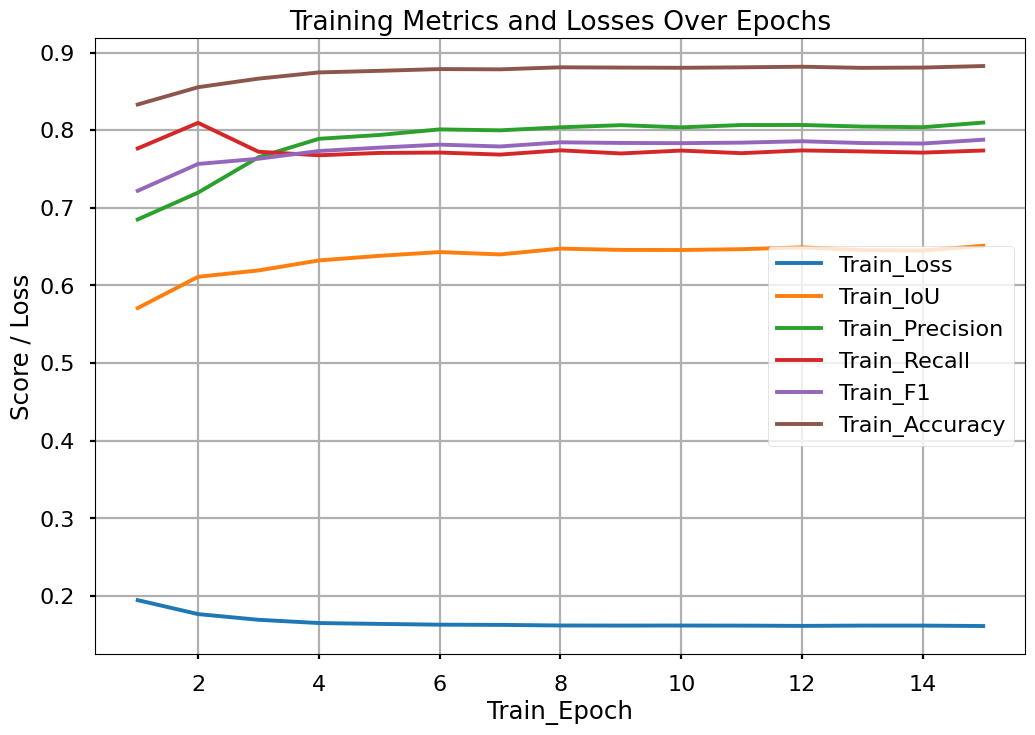

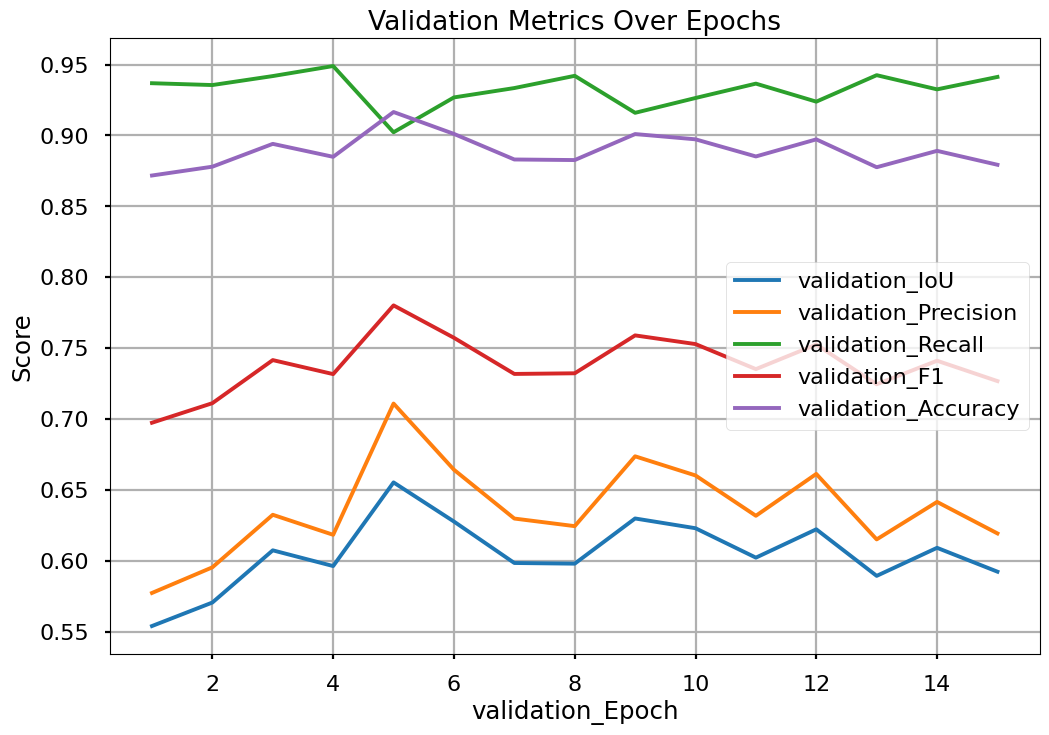

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
            Conv2d-2         [-1, 64, 256, 256]           1,792
       BatchNorm2d-3         [-1, 64, 256, 256]             128
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]          36,928
            Conv2d-8         [-1, 64, 256, 256]          36,928
       BatchNorm2d-9         [-1, 64, 256, 256]             128
      BatchNorm2d-10         [-1, 64, 256, 256]             128
             ReLU-11         [-1, 64, 256, 256]               0
             ReLU-12         [-1, 64, 256, 256]               0
        MaxPool2d-13         [-1, 64, 128, 128]               0
        MaxPool2d-14         [-1, 64, 1

In [18]:
def main():
  train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 1.0
      ),
      ToTensorV2(),
    ], is_check_shapes=False
  )

  val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.RandomCrop(height = IMAGE_HEIGHT,width=IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 1.0
    ),
    ToTensorV2(),
  ], is_check_shapes=False
  )

  train_loader,val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      val_dir,
      val_mask_dir,
      BATCH_SIZE,
      train_transform,
      val_transform,
      train_val,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  model = vgg16bn_unet().to(DEVICE)
  loss_fn = FocalLoss()

  optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

  # if LOAD_MODEL:
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model)
    # load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

  scaler = torch.cuda.amp.GradScaler()

  # Initialize lists to store metric values for each epoch for validation dataset
  iou_scores = []
  precision_scores = []
  recall_scores = []
  f1_val = []
  dice_scores = []
  accuracy_vals = []

  # Initialize lists to store metric values for each epoch for training dataset
  iou_train = []
  precision_train = []
  recall_train = []
  f1_train = []
  loss_train = []
  accuracy_train = []

  # Number of patience for early stopping
  patience = 10
  # best_val_loss = float('inf')
  best_val_loss = torch.tensor(float('inf'))
  counter = 0

  for epoch in range(NUM_EPOCHS):
    scheduler.step()
    train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check_accuracy
    val_loss = 0.0
    check_accuracy(loss_fn,val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,val_loss,device = DEVICE)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping triggered.")
#             break

    # print some examples to the folder
    save_predictions_as_imgs(
        val_loader,model,folder=saved_folder,device = DEVICE
    )
  print("Training finished")
  print(f'loss_train : {loss_train}')
  print(f'iou_train : {iou_train}')
  print(f'precision_train : {precision_train}')
  print(f'recall_train : {recall_train}')
  print(f'f1_train : {f1_train}')
  
  print(f'Validation result')
  print(f'f1_val: {f1_val}')
  print(f'dice_scores : {dice_scores}')
  print(f'iou_scores : {iou_scores}')
  print(f'precision_scores : {precision_scores}')
  print(f'recall_scores : {recall_scores}')
  print(f'Accuracy_scores : {accuracy_vals}')

  # Plot metrics and losses
  # Plot for Training dataset
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, dice_scores, label='validation_F1')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  summary(model,input_size = (3,IMAGE_HEIGHT,IMAGE_WIDTH))

if __name__ == "__main__":
  main()